📚 **Importar librerías**

In [1]:
# librerías base para data science
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# configuración para que solo se muestren 2 decimales
pd.set_option("display.float_format", "{:.2f}".format)

💾 **Cargar datos**

In [3]:
BASE_DIR = Path("/home/lof/Projects/Telco-Customer-Churn")
DATA_DIR = BASE_DIR / "data" / "interim"
churn_df = pd.read_parquet(
    DATA_DIR / "churn_type_fixed.parquet", engine="pyarrow")

📊 **Descripción del dataframe**

In [4]:
# información general
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24742 entries, 0 to 24741
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MonthlyCharges    24527 non-null  float64 
 1   StreamingMovies   24415 non-null  category
 2   Partner           24742 non-null  bool    
 3   PhoneService      24742 non-null  bool    
 4   InternetService   24445 non-null  category
 5   StreamingTV       24375 non-null  category
 6   OnlineSecurity    24393 non-null  category
 7   MultipleLines     24493 non-null  category
 8   Dependents        24742 non-null  bool    
 9   DeviceProtection  24383 non-null  category
 10  SeniorCitizen     24742 non-null  bool    
 11  TotalCharges      24560 non-null  float64 
 12  TechSupport       24379 non-null  category
 13  gender            24684 non-null  category
 14  PaperlessBilling  24742 non-null  bool    
 15  tenure            24562 non-null  float64 
 16  Churn             2474

In [5]:
# tamaño del dataframe
churn_df.shape

(24742, 20)

In [6]:
# algunos registros
churn_df.sample(5)

,MonthlyCharges,StreamingMovies,Partner,PhoneService,InternetService,StreamingTV,OnlineSecurity,MultipleLines,Dependents,DeviceProtection,SeniorCitizen,TotalCharges,TechSupport,gender,PaperlessBilling,tenure,Churn,OnlineBackup,PaymentMethod,Contract
17856,74.05,Yes,False,True,DSL,No,Yes,Yes,False,No,False,3496.30,Yes,Female,False,47.00,False,Yes,Mailed check,Two year
22039,24.45,No internet service,True,True,No,No internet service,No internet service,Yes,True,No internet service,False,1431.65,No internet service,Male,True,56.00,False,No internet service,Mailed check,One year
15560,25.10,No internet service,False,True,No,No internet service,No internet service,Yes,False,No internet service,True,1672.15,No internet service,Male,False,67.00,False,No internet service,Credit card (automatic),Two year
1595,100.20,Yes,True,True,Fiber optic,Yes,No,Yes,False,No,True,6851.65,No,Female,True,68.00,True,Yes,Electronic check,Month-to-month
12754,95.95,Yes,False,True,Fiber optic,No,Yes,No,True,Yes,False,5036.90,No,Male,False,53.00,False,Yes,Electronic check,One year


In [7]:
nulls_perc = (churn_df.isnull().sum() / len(churn_df) * 100).round(2)

pd.DataFrame({
    "Null count" : churn_df.isnull().sum(),
    "Null %" : nulls_perc,
    "Dtype": churn_df.dtypes
}) 

,Null count,Null %,Dtype
MonthlyCharges,215,0.87,float64
StreamingMovies,327,1.32,category
Partner,0,0.00,bool
PhoneService,0,0.00,bool
InternetService,297,1.20,category
StreamingTV,367,1.48,category
OnlineSecurity,349,1.41,category
MultipleLines,249,1.01,category
Dependents,0,0.00,bool
DeviceProtection,359,1.45,category


No hay un número de valores nulos representativos dentro de las columnas para descartar una de ellas

Variable target: **'Churn'**

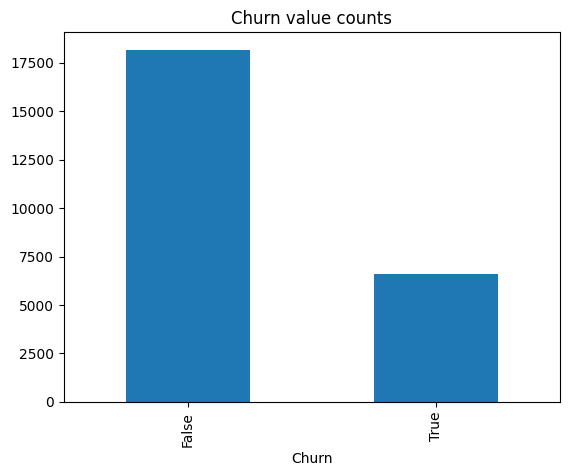

In [8]:
churn_df['Churn'].value_counts().plot(
        kind="bar", title = f"Churn value counts"
    )
plt.show()

Antes de entrar a analizar las variables debemos observar si existen registros duplicados que nos puedan mostrar un analisis incorrecto del dataset

In [9]:
churn_df.duplicated().sum()

np.int64(17830)

El total de datos de este dataset es 24742 y el valor de los registros duplicados es más de la mitad, por lo cual los eliminaremos antes de comenzar el analisis

In [10]:
churn_df.drop_duplicates(inplace=True, keep="first")
churn_df.duplicated().sum() # Comprobación de existencia de duplicados

np.int64(0)

Ahora investigaremos los outliers para lograr tener un analisis más adecuado

In [11]:
churn_df.describe()

,MonthlyCharges,TotalCharges,tenure
count,6836.00,6859.00,6851.00
mean,767391474.51,792199942.67,32.47
std,63417377053.06,65728553144.59,24.49
min,18.25,-9876543456.00,0.00
25%,35.69,411.93,9.00
50%,70.35,1411.35,29.00
75%,89.85,3805.88,55.00
max,5243355243554.00,5443567897654.00,72.00


Es evidente que las columnas 'MonthlyCharges' y 'TotalCharges' tienen valores atipicos ya que no pueden haber cobros negativos ni cargos mensuales mayores de por lo menos 1.000 USD, debemos hacernos cargo de estos outliers o nos darán problemas luego en nuestro analisis

In [12]:
# Contar los datos que NO cumplen las condiciones dadas
num_outliers = churn_df.shape[0] - churn_df[
    (churn_df["MonthlyCharges"] > 0) & (churn_df["MonthlyCharges"] < 500) &
    (churn_df["TotalCharges"] > 0) & (churn_df["TotalCharges"] < 20000)
].shape[0]

print(f"Número de registros que NO cumplen las condiciones {num_outliers} de {churn_df.shape[0]} posibles")

Número de registros que NO cumplen las condiciones 98 de 6912 posibles


Este valor representa el 1% del total de los datos, pero no los eliminaré, los pondré como np.nan para posteriormente hacer una imputación por KNN ya que son cuentas de cobro de acuerdo a los servicios prestados de una empresa de comunicaciones, por lo que sería de alguna forma fácil estimar el valor de los vcargos de acuerdo a los servicios que tengan

In [13]:
# Reemplazar los valores fuera de rango por np.nan
churn_df.loc[
    ~((churn_df["MonthlyCharges"] > 0) & (churn_df["MonthlyCharges"] < 500) &
      (churn_df["TotalCharges"] > 0) & (churn_df["TotalCharges"] < 20000)),
    ["MonthlyCharges", "TotalCharges"]
] = np.nan

# Verificar cuántos valores NaN quedaron
print(churn_df.isna().sum())

MonthlyCharges       98
StreamingMovies     128
Partner               0
PhoneService          0
InternetService     113
StreamingTV         144
OnlineSecurity      139
MultipleLines        92
Dependents            0
DeviceProtection    142
SeniorCitizen         0
TotalCharges         98
TechSupport         143
gender                3
PaperlessBilling      0
tenure               61
Churn                 0
OnlineBackup        145
PaymentMethod        85
Contract             84
dtype: int64


### 📈 **Análisis univariable**

**Variables númericas**

In [14]:
# list of the numerical columns
numerical_columns = list(churn_df.select_dtypes(include=["number"]).columns)
numerical_columns

['MonthlyCharges', 'TotalCharges', 'tenure']

In [15]:
churn_df.describe()

,MonthlyCharges,TotalCharges,tenure
count,6814.00,6814.00,6851.00
mean,64.83,2284.47,32.47
std,30.06,2257.94,24.49
min,18.25,18.80,0.00
25%,35.75,411.49,9.00
50%,70.38,1405.65,29.00
75%,89.85,3799.84,55.00
max,118.75,8684.80,72.00


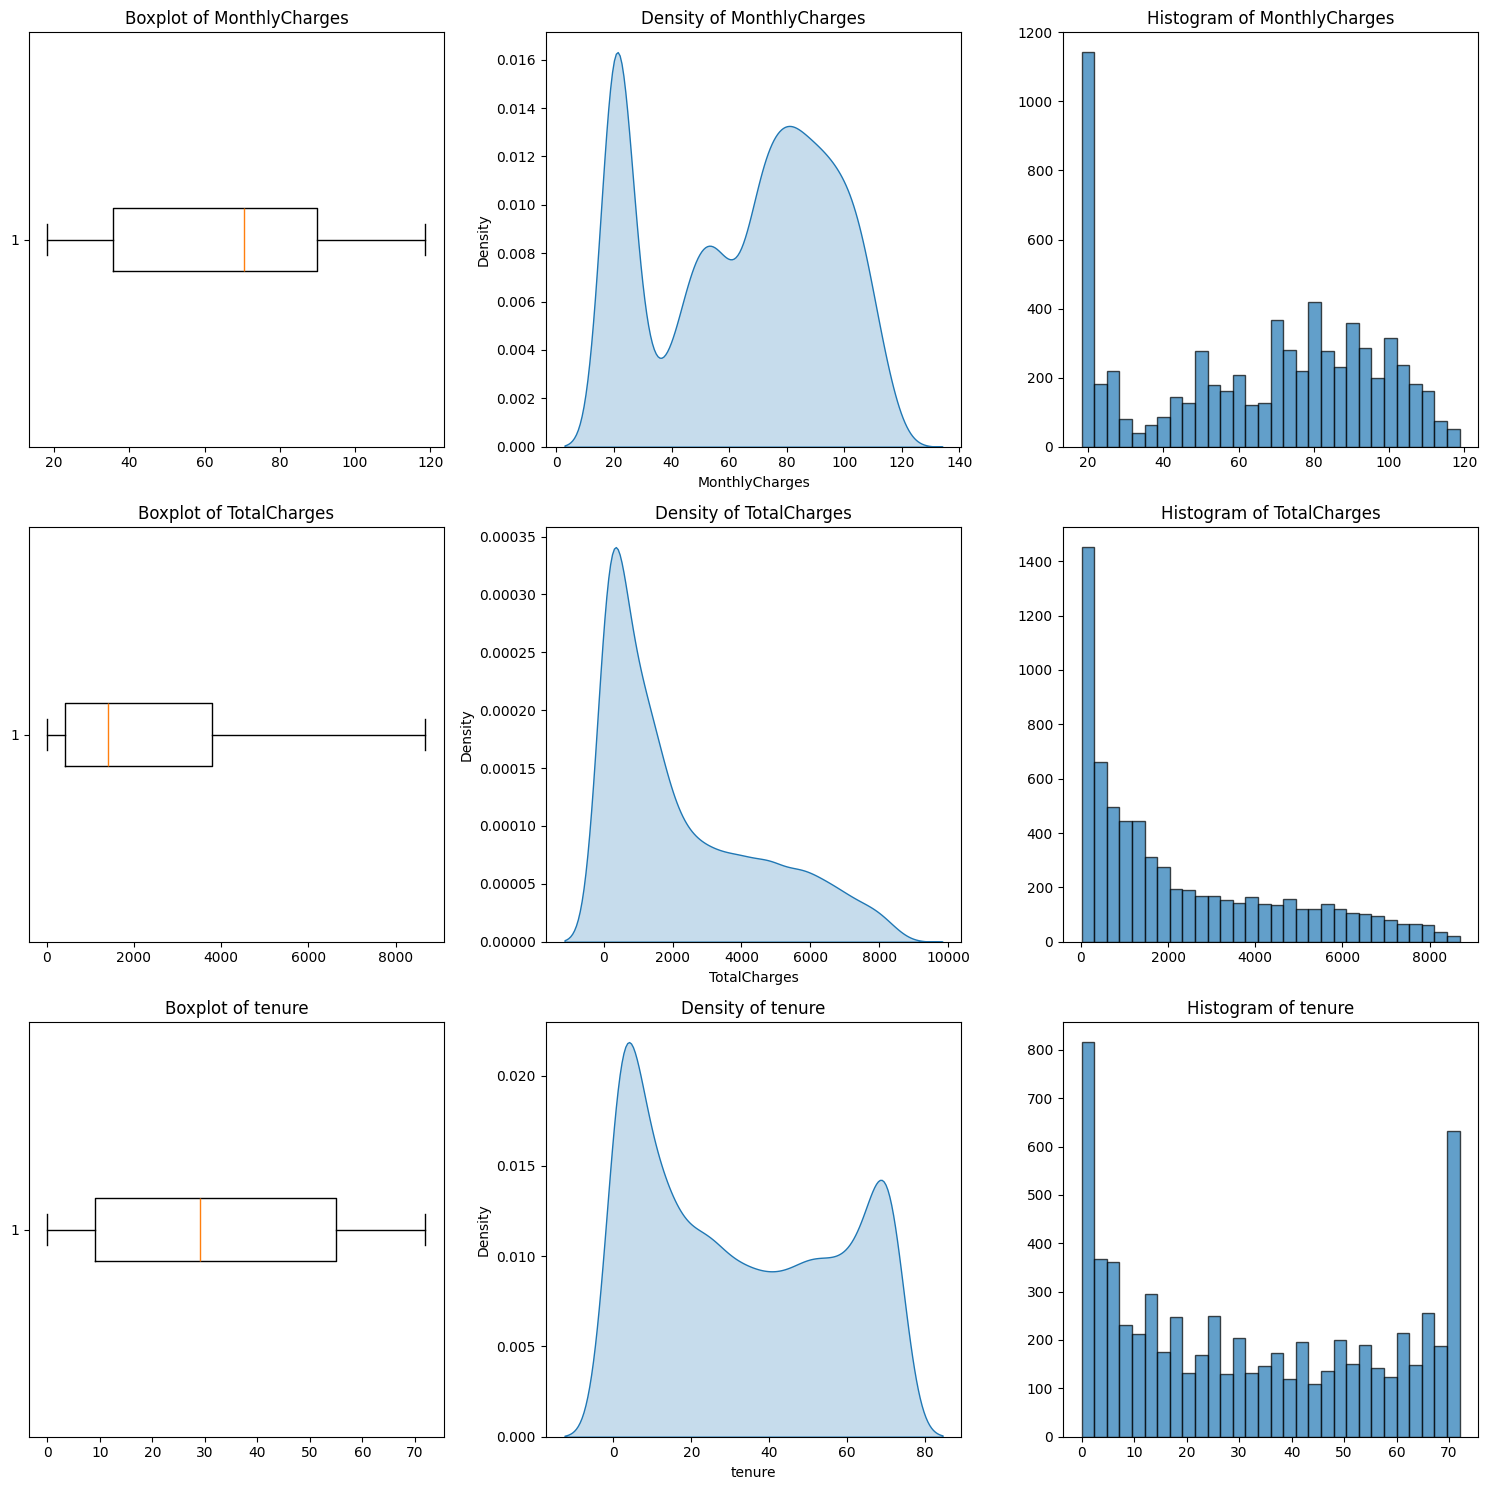

In [16]:
num_cols = list(churn_df.select_dtypes(include=["number"]).columns)

fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    axes[i, 0].boxplot(churn_df[col].dropna(), vert=False)
    axes[i, 0].set_title(f"Boxplot of {col}")

    # Density plot (approximation using histogram)
    sns.kdeplot(churn_df[col], fill=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Density of {col}")

    # Histogram
    axes[i, 2].hist(churn_df[col].dropna(), bins=30, edgecolor="black", alpha=0.7)
    axes[i, 2].set_title(f"Histogram of {col}")
plt.tight_layout()
plt.show()

**Variables categoricas**

In [17]:
# descripción de columnas categoricas
churn_df.describe(include="category")

,StreamingMovies,InternetService,StreamingTV,OnlineSecurity,MultipleLines,DeviceProtection,TechSupport,gender,OnlineBackup,PaymentMethod,Contract
count,6784,6799,6768,6773,6820,6770,6769,6909,6767,6827,6828
unique,4,3,4,3,4,4,3,2,3,4,3
top,No,Fiber optic,No,No,No,No,No,Male,No,Electronic check,Month-to-month
freq,2684,2978,2694,3352,3272,2971,3322,3502,2962,2289,3739


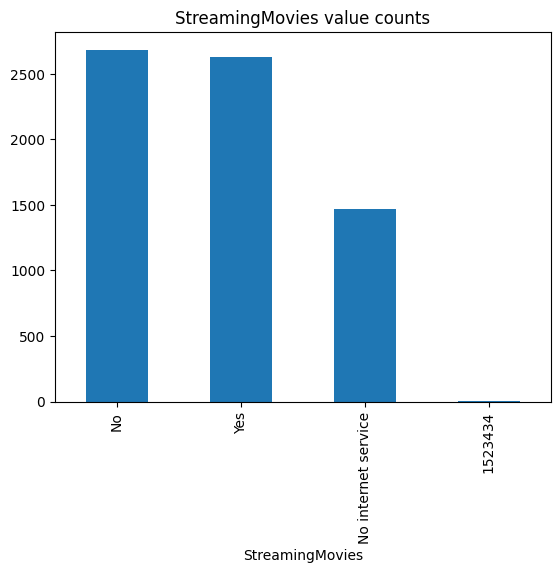

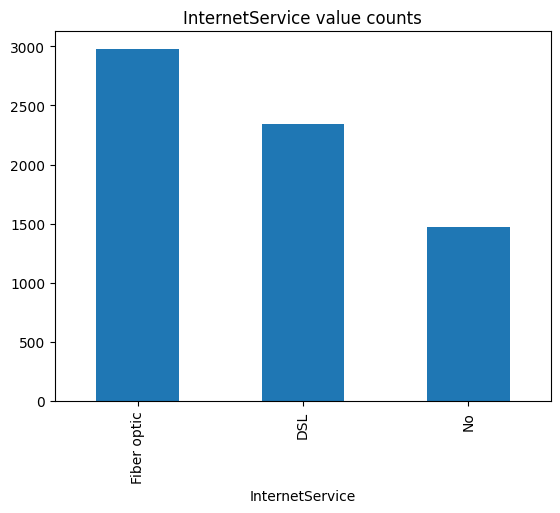

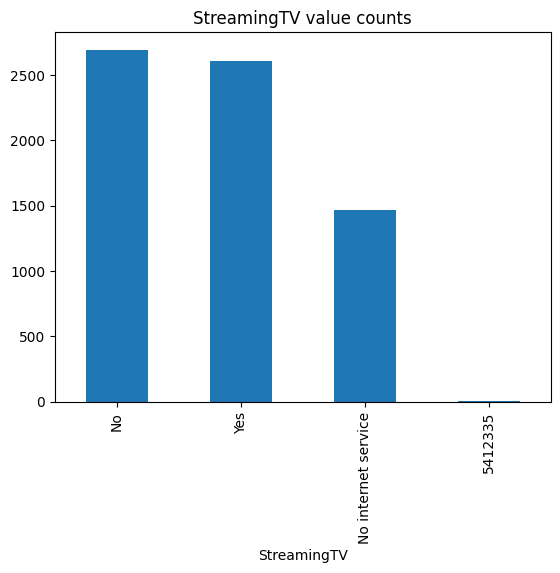

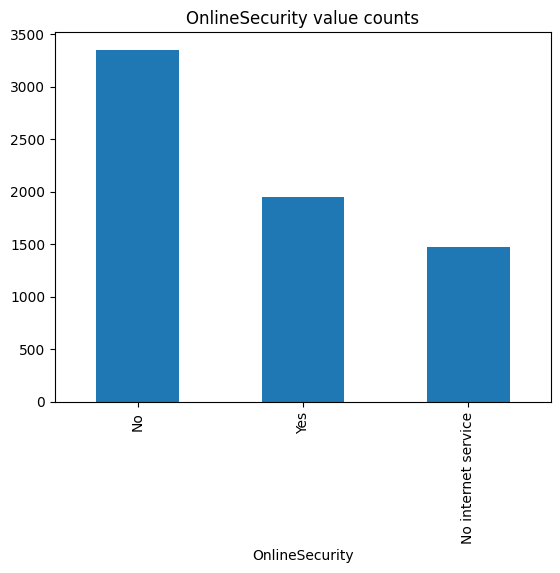

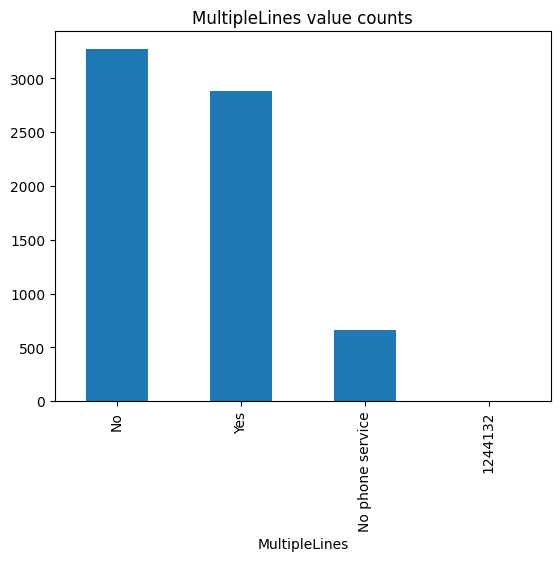

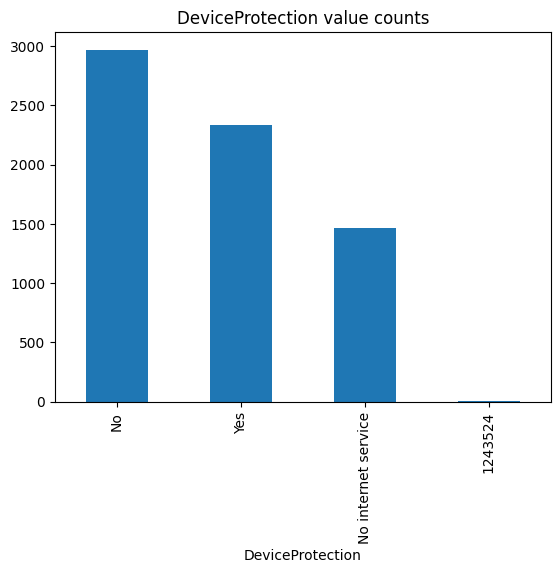

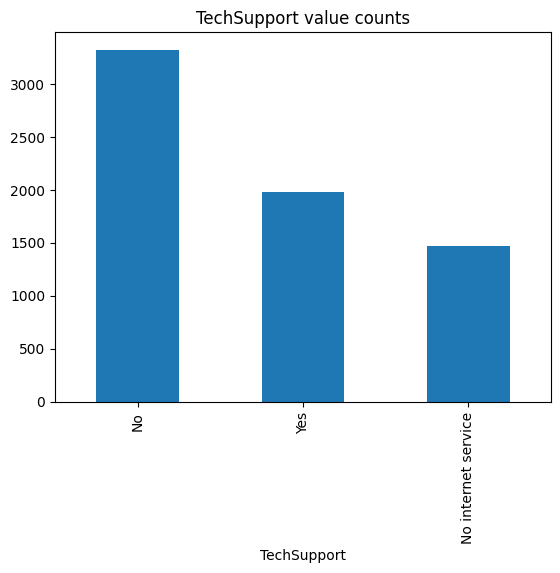

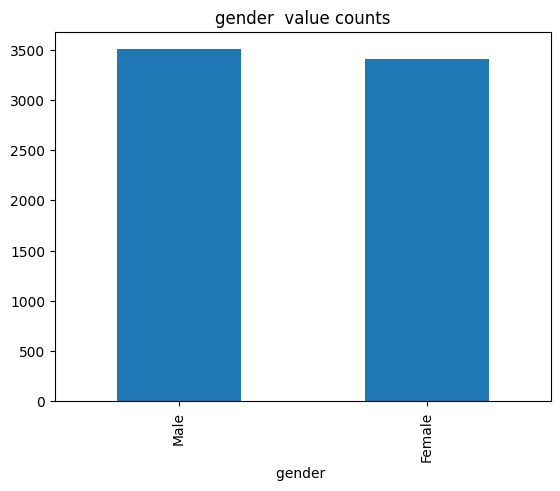

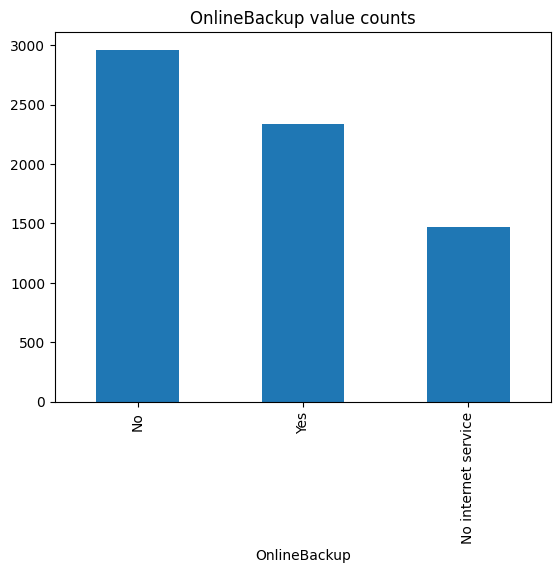

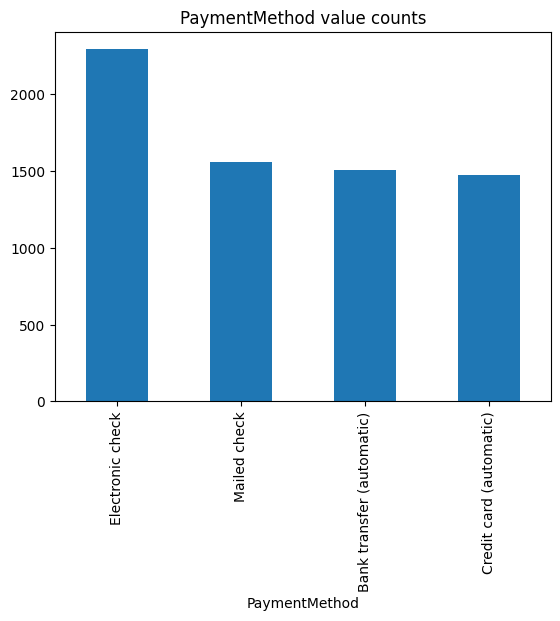

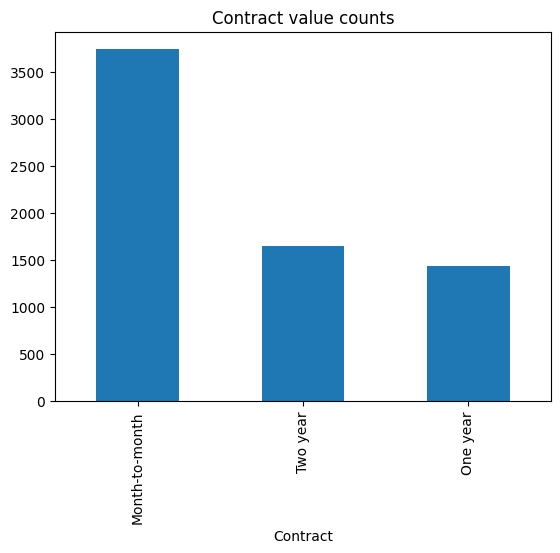

In [18]:
cat_cols = list(churn_df.select_dtypes(include=["category"]).columns)

for col in cat_cols:
    churn_df[col].value_counts().plot(
        kind="bar", title = f"{col} value counts"
    )
    plt.show()

### 📈 **Bivariate Analysis**

Es importante revisar la relación entre la variable target y las otras variables

**Target vs Variables Numericas**

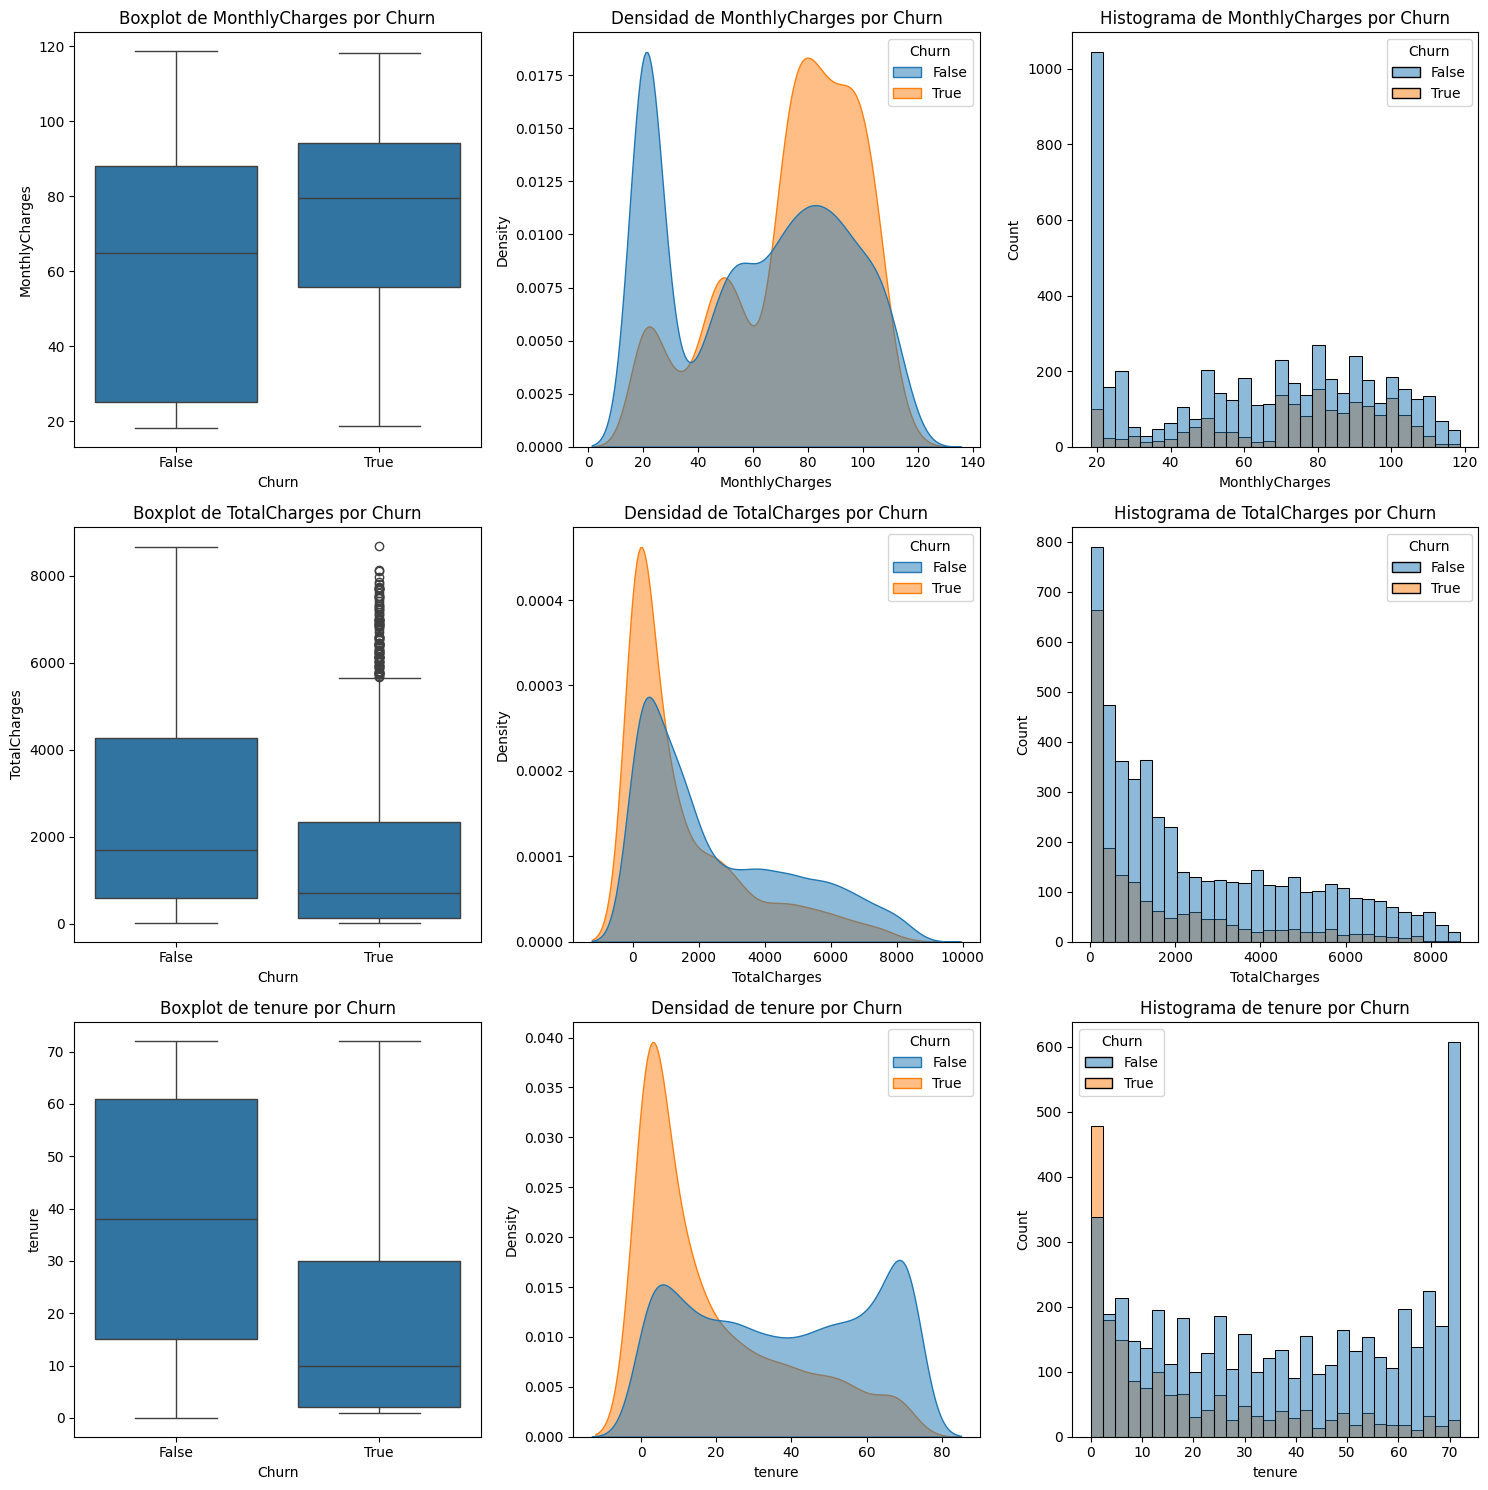

In [19]:
fig, axes = plt.subplots(nrows=len(num_cols), ncols=3, figsize=(15, 5 * len(num_cols)))

for i, col in enumerate(num_cols):
    sns.boxplot(x="Churn", y=col, data=churn_df, ax=axes[i, 0])
    axes[i, 0].set_title(f"Boxplot de {col} por Churn")
    
    sns.kdeplot(data=churn_df, x=col, hue="Churn", fill=True, common_norm=False, alpha=0.5, ax=axes[i, 1])
    axes[i, 1].set_title(f"Densidad de {col} por Churn")
    
    sns.histplot(data=churn_df, x=col, hue="Churn", bins=30, kde=False, alpha=0.5, ax=axes[i, 2])
    axes[i, 2].set_title(f"Histograma de {col} por Churn")

plt.tight_layout()
plt.show()